### Chapter 16: Bayesian statistics
* Bayes stats: probabilities = degree of belief instead of observations.
* Initial system knowledge: "prior probability" distribution
* Updated system knowledge: "posterior probability" distribution
* Multi methods available for finding PP distribution. Most common: **Markov Chain Monte Carlo (MCMC)** methods.

### Simple refresher
* Relation between unconditional & conditional probabilities of two events A & B: *P(A|B) P(B) = P(B|A) P(A)*
* P(A|B) = conditional prob of A given B being true
* P(B|A) = conditional prob of B given A being true
* Use case: situations where we want to update P(A) based on event B.

In [11]:
import pymc3 as mc 

In [12]:
import numpy as np

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

In [14]:
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

In [15]:
# try this
dir(mc.distributions)

['AR1',
 'Bernoulli',
 'Beta',
 'BetaBinomial',
 'Binomial',
 'Bound',
 'Categorical',
 'Cauchy',
 'ChiSquared',
 'Constant',
 'ConstantDist',
 'Continuous',
 'DensityDist',
 'Dirichlet',
 'Discrete',
 'DiscreteUniform',
 'Distribution',
 'ExGaussian',
 'Exponential',
 'Flat',
 'GARCH11',
 'Gamma',
 'GaussianRandomWalk',
 'Geometric',
 'HalfCauchy',
 'HalfNormal',
 'HalfStudentT',
 'InverseGamma',
 'LKJCorr',
 'Laplace',
 'Lognormal',
 'Mixture',
 'Multinomial',
 'MvNormal',
 'MvStudentT',
 'NegativeBinomial',
 'NoDistribution',
 'Normal',
 'NormalMixture',
 'Pareto',
 'Poisson',
 'SkewNormal',
 'StudentT',
 'StudentTpos',
 'TensorType',
 'Uniform',
 'VonMises',
 'Wald',
 'Weibull',
 'Wishart',
 'WishartBartlett',
 'ZeroInflatedNegativeBinomial',
 'ZeroInflatedPoisson',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'continuous',
 'discrete',
 'dist_math',
 'distribution',
 'draw_values',
 'log

### Simple example: Normal distributed random variable

In [24]:
np.random.seed(100)

In [25]:
mu    = 4.0
sigma = 2.0
model = mc.Model()

In [26]:
with model:
    mc.Normal('X', mu, 1/sigma**2)
model.vars

[X]

In [27]:
start = dict(X=2)

In [28]:
# mc.sample() -- implements MCMC for sampling from random vars in model
with model:
    step = mc.Metropolis()
    trace = mc.sample(10000, step=step, start=start)

100%|██████████| 10000/10000 [00:00<00:00, 16270.86it/s]


In [29]:
# now have 10K values from random variable.
# use get_values() to access them
# y = PDF of distribution

x = np.linspace(-4, 12, 1000)
y = stats.norm(mu, sigma).pdf(x)
X = trace.get_values("X")

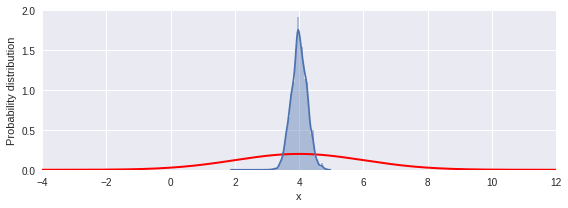

In [30]:
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(x, y, 'r', lw=2)
sns.distplot(X, ax=ax)
ax.set_xlim(-4, 12)
ax.set_xlabel("x")
ax.set_ylabel("Probability distribution")
fig.tight_layout()
fig.savefig("ch16-normal-distribution-sampled.pdf")

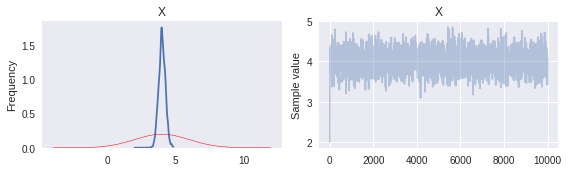

In [31]:
# viz MCMC random walk == source data
# mc.traceplot == kernel density plot & sampling trace (automatic)

fig, axes = plt.subplots(1, 2, figsize=(8, 2.5), squeeze=False)
mc.traceplot(trace, ax=axes)
axes[0,0].plot(x, y, 'r', lw=0.5)
fig.tight_layout()
fig.savefig("ch16-normal-sampling-trace.png")
fig.savefig("ch16-normal-sampling-trace.pdf")

### Dependent random variables

In [36]:
model = mc.Model()

In [37]:
# normal distr, but both mean & sigma are themselves normal distribs
with model:
    mean = mc.Normal('mean', 3.0)
    sigma = mc.HalfNormal('sigma', sd=1.0)
    X = mc.Normal('X', mean, sd=sigma)

In [38]:
model.vars

[mean, sigma_log_, X]

In [39]:
# not so easy to find good starting point for sampling
# use find_MAP() instead -- corresponds to maxx posterior distribution
with model:
    start = mc.find_MAP()

Optimization terminated successfully.
         Current function value: 2.063672
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17


In [40]:
start

{'X': array(3.0), 'mean': array(3.0), 'sigma_log_': array(-5.990881458971846)}

In [41]:
# now we can start sampling
with model:
    step = mc.Metropolis()
    trace = mc.sample(100000, start=start, step=step)

100%|██████████| 100000/100000 [00:16<00:00, 5899.07it/s]


In [42]:
# result = NumPy array with sample values
# can be used for stats
trace.get_values('sigma').mean()

0.8219816833485929

In [43]:
# same approach can be used with X
X = trace.get_values('X')

In [44]:
X.mean()

2.9565878858789767

In [45]:
trace.get_values('X').std()

1.4324234516333139

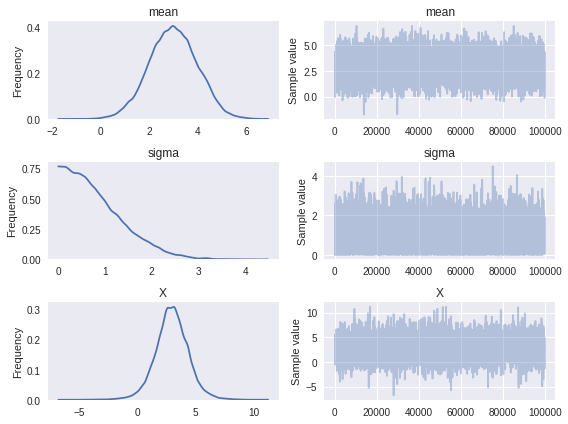

In [46]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), squeeze=False)
mc.traceplot(trace, varnames=['mean', 'sigma', 'X'], ax=axes)
fig.tight_layout()
fig.savefig("ch16-dependent-rv-sample-trace.png")
fig.savefig("ch16-dependent-rv-sample-trace.pdf")

### Sampling Posterior distributions
* Bayes' real use case: sampling from posterior distribution == probability distrs for updated model variables.
* To condition model, use observed=data in model definition

In [49]:
# norm distrib, mean 2.5, sigma 1.5
mu = 2.5
s = 1.5
data = stats.norm(mu, s).rvs(100)
data[0:10]

array([ 0.45598376,  0.56555613,  2.49893641,  3.978023  ,  2.71354689,
        1.56389224,  2.68839463,  4.4411751 ,  3.74339254,  2.62927864])

In [50]:
with mc.Model() as model:
    
    mean  = mc.Normal('mean', 4.0, 1.0) # true 2.5
    sigma = mc.HalfNormal('sigma', 3.0 * np.sqrt(np.pi/2)) # true 1.5

    X = mc.Normal('X', mean, 1/sigma**2, observed=data)

In [52]:
# X no longer used to construct likelihoods
model.vars

[mean, sigma_log_]

In [53]:
# 
with model:
    start = mc.find_MAP()         # find appropriate start point
    step =  mc.Metropolis()       # step instance
    trace = mc.sample(100000, start=start, step=step)
    #step = mc.NUTS()
    #trace = mc.sample(10000, start=start, step=step)

Optimization terminated successfully.
         Current function value: 187.304524
         Iterations: 15
         Function evaluations: 19

100%|██████████| 100000/100000 [00:14<00:00, 6919.95it/s]


         Gradient evaluations: 19


In [54]:
start

{'mean': array(2.4049743290420094), 'sigma_log_': array(-0.20600880617494624)}

In [55]:
model.vars

[mean, sigma_log_]

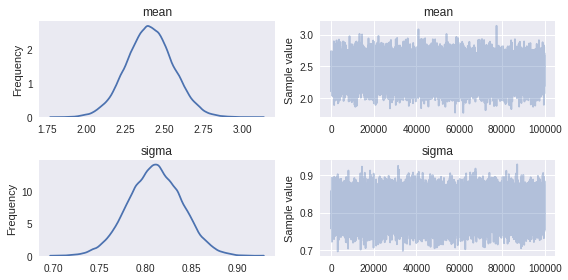

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(8, 4), squeeze=False)
mc.traceplot(trace, varnames=['mean', 'sigma'], ax=axes)
fig.tight_layout()
fig.savefig("ch16-posterior-sample-trace.png")
fig.savefig("ch16-posterior-sample-trace.pdf")

In [57]:
# to get stats, access arrays using get_values with var name as arg
mu, trace.get_values('mean').mean()

(2.5, 2.4059325926349997)

In [58]:
s, trace.get_values('sigma').mean()

(1.5, 0.81004398217076157)

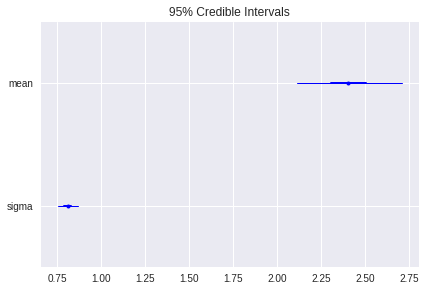

In [59]:
# forestplot = viz of mean & credibility intervals
# for each random var in a model
gs = mc.forestplot(trace, varnames=['mean', 'sigma'])
plt.savefig("ch16-forestplot.pdf")

In [60]:
mc.summary

<function pymc3.stats.summary>

In [61]:
mc.summary(trace, varnames=['mean', 'sigma'])


mean:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.406            0.151            0.001            [2.112, 2.708]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  2.109          2.306          2.405          2.506          2.705


sigma:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.810            0.029            0.000            [0.754, 0.866]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.753          0.790          0.810          0.830          0.866



### Linear regression
* use case: assigning prior probabilities to unknown slopes & intercepts.

In [62]:
# height & weight for 200 men & women
dataset = sm.datasets.get_rdataset("Davis", "car")

In [63]:
# use only males for now
# use only males < 100kg for now
data = dataset.data[dataset.data.sex == 'M']
data = data[data.weight < 110]
data.head(3)

,sex,weight,height,repwt,repht
0,M,77,182,77.0,180.0
3,M,68,177,70.0,175.0
5,M,76,170,76.0,165.0


In [64]:
# use statsmodel library
# ordinary least squares regrsssion
# patsy formula for height vs weight
model = smf.ols("height ~ weight", data=data)

In [65]:
result = model.fit()

In [66]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 height   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     41.35
Date:                Wed, 10 May 2017   Prob (F-statistic):           7.11e-09
Time:                        14:05:50   Log-Likelihood:                -268.20
No. Observations:                  87   AIC:                             540.4
Df Residuals:                      85   BIC:                             545.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    152.6173      3.987     38.281      0.000     144.691     160.544
weight         0.3365      0.052      6.431      0.000       0.232       0.441
==============================================================================
Omnibus:                        5.734   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                5.660
Skew:                           0.397   Prob(JB):                       0.0590
Kurtosis:                       3.965   Cond. No.                         531.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
# model in place. let's use predict() method to try it out.
x = np.linspace(50, 110, 25)
y = result.predict({"weight": x})

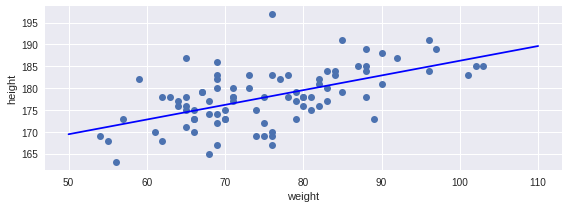

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(data.weight, data.height, 'o')
ax.plot(x, y, color="blue")
ax.set_xlabel("weight")
ax.set_ylabel("height")
fig.tight_layout()
fig.savefig("ch16-linear-ols-fit.pdf")

In [69]:
# creditbility interval = describes uncertainty in estimate

with mc.Model() as model:
    sigma     = mc.Uniform('sigma', 0, 10)
    intercept = mc.Normal('intercept', 125, sd=30)
    beta      = mc.Normal('beta', 0, sd=5)
    
    height_mu = intercept + beta * data.weight

    # likelihood function
    mc.Normal('height', mu=height_mu, sd=sigma, observed=data.height)

    # predict
    predict_height = mc.Normal('predict_height', mu=intercept + beta * x, sd=sigma, shape=len(x)) 

In [70]:
model.vars

[sigma_interval_, intercept, beta, predict_height]

In [72]:
with model:
    start = mc.find_MAP()
    step = mc.NUTS(state=start)
    trace = mc.sample(10000, step, start=start)

Optimization terminated successfully.
         Current function value: 339.789864
         Iterations: 54
         Function evaluations: 74
         Gradient evaluations: 74

100%|██████████| 10000/10000 [00:19<00:00, 510.42it/s]

In [73]:
model.vars

[sigma_interval_, intercept, beta, predict_height]

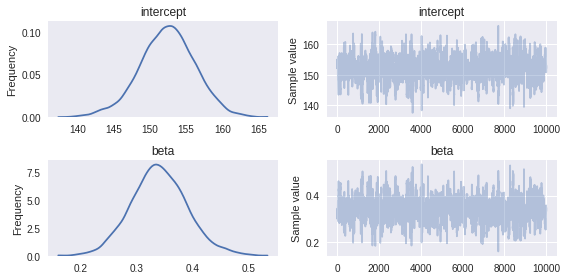

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(8, 4), squeeze=False)
mc.traceplot(trace, varnames=['intercept', 'beta'], ax=axes)
fig.savefig("ch16-linear-model-sample-trace.pdf")
fig.savefig("ch16-linear-model-sample-trace.png")

In [75]:
intercept = trace.get_values("intercept").mean()
beta      = trace.get_values("beta").mean()

In [76]:
intercept, beta

(152.3558161144345, 0.33981749294464142)

In [77]:
result.params

Intercept    152.617348
weight         0.336477
dtype: float64

In [79]:
#result.predict({"weight": 90})

In [80]:
weight_index = np.where(x == 90)[0][0]

In [81]:
trace.get_values("predict_height")[:, weight_index].mean()

182.94710921928788

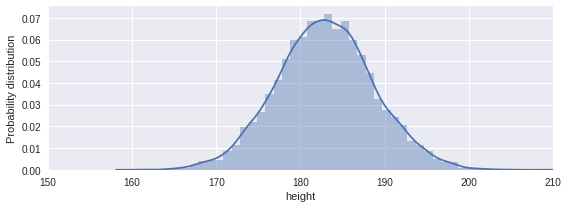

In [82]:
fig, ax = plt.subplots(figsize=(8, 3))

sns.distplot(trace.get_values("predict_height")[:, weight_index], ax=ax)
ax.set_xlim(150, 210)
ax.set_xlabel("height")
ax.set_ylabel("Probability distribution")
fig.tight_layout()
fig.savefig("ch16-linear-model-predict-cut.pdf")

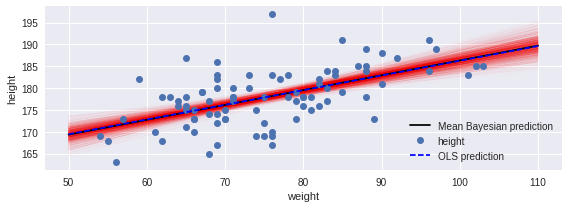

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

for n in range(500, 2000, 1):
    intercept = trace.get_values("intercept")[n]
    beta      = trace.get_values("beta")[n]
    
    ax.plot(x, 
            intercept + beta * x, 
            color='red', 
            lw=0.25, 
            alpha=0.05)

intercept = trace.get_values("intercept").mean()
beta      = trace.get_values("beta").mean()

ax.plot(x, intercept + beta * x, 
        color='k', 
        label="Mean Bayesian prediction")

ax.plot(data.weight, data.height, 'o')
ax.plot(x, y, '--', color="blue", label="OLS prediction")
ax.set_xlabel("weight")
ax.set_ylabel("height")
ax.legend(loc=0)

fig.tight_layout()
fig.savefig("ch16-linear-model-fit.pdf")
fig.savefig("ch16-linear-model-fit.png")

In [85]:
# for general-purpose linear models
# PyMC provides simple API to create model & stochastic vars

with mc.Model() as model:
    mc.glm.glm('height ~ weight', data)
    step = mc.NUTS()
    trace = mc.sample(2000, step)

100%|██████████| 2000/2000 [00:25<00:00, 78.21it/s] 


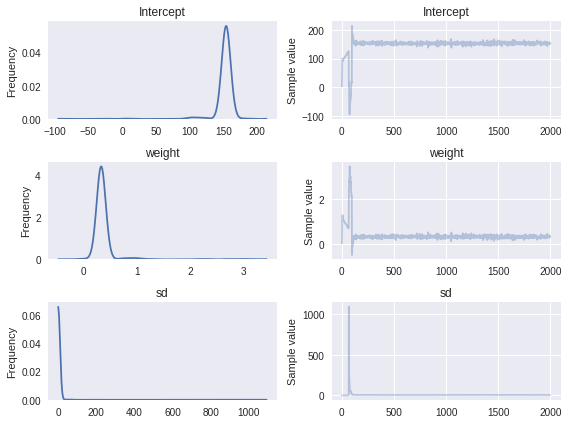

In [87]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), squeeze=False)

# traceplot
# sd = sigma in model definition, indicates std error of residual
# note in plot how sampling needs ~100 points before steady state

mc.traceplot(
    trace, 
    varnames=['Intercept', 'weight', 'sd'], 
    ax=axes)

fig.tight_layout()
fig.savefig("ch16-glm-sample-trace.pdf")
fig.savefig("ch16-glm-sample-trace.png")

### Multilevel model

In [89]:
dataset = sm.datasets.get_rdataset("Davis", "car")

In [92]:
data = dataset.data.copy()
data = data[data.weight < 110]
data["sex"] = data["sex"].apply(lambda x: 1 if x == "F" else 0)
data.head()

,sex,weight,height,repwt,repht
0,0,77,182,77.0,180.0
1,1,58,161,51.0,159.0
2,1,53,161,54.0,158.0
3,0,68,177,70.0,175.0
4,1,59,157,59.0,155.0


In [93]:
with mc.Model() as model:

    # heirarchical model: hyper priors
    #intercept_mu = mc.Normal("intercept_mu", 125)
    #intercept_sigma = 30.0 #mc.Uniform('intercept_sigma', lower=0, upper=50)
    #beta_mu = mc.Normal("beta_mu", 0.0)
    #beta_sigma = 5.0 #mc.Uniform('beta_sigma', lower=0, upper=10)
    
    # multilevel model: prior parameters
    intercept_mu, intercept_sigma = 125, 30
    beta_mu, beta_sigma = 0.0, 5.0
    
    # priors
    intercept = mc.Normal('intercept', intercept_mu, sd=intercept_sigma, shape=2)
    beta = mc.Normal('beta', beta_mu, sd=beta_sigma, shape=2)
    error = mc.Uniform('error', 0, 10)

    # model equation
    sex_idx = data.sex.values
    height_mu = intercept[sex_idx] + beta[sex_idx] * data.weight

    mc.Normal('height', mu=height_mu, sd=error, observed=data.height)

In [94]:
model.vars

[intercept, beta, error_interval_]

In [95]:
# invoke MCMC (NUTS) sampler - collect 5K samples
with model:
    start = mc.find_MAP()
    step = mc.NUTS(state=start)
    hessian = mc.find_hessian(start)
    trace = mc.sample(5000, step, start=start)

         Current function value: 617.047108
         Iterations: 26
         Function evaluations: 105

100%|██████████| 5000/5000 [00:39<00:00, 125.01it/s]


         Gradient evaluations: 93


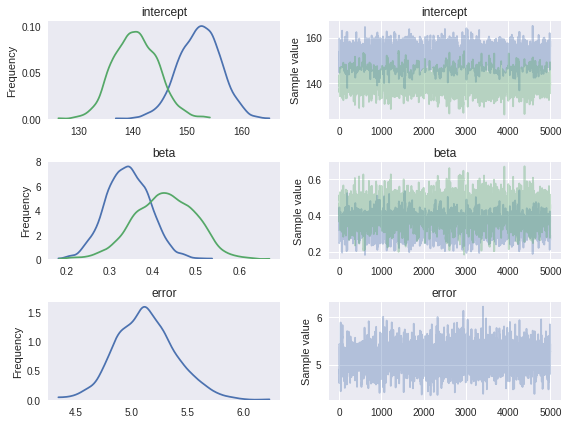

In [96]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), squeeze=False)

# again use traceplot. blue = male, green = female

mc.traceplot(
    trace, 
    varnames=['intercept', 'beta', 'error'], 
    ax=axes)

fig.tight_layout()
fig.savefig("ch16-multilevel-sample-trace.pdf")
fig.savefig("ch16-multilevel-sample-trace.png")

In [98]:
intercept_m, intercept_f = trace.get_values('intercept').mean(axis=0)

In [99]:
intercept = trace.get_values('intercept').mean()
intercept

146.33486241015748

In [101]:
beta_m, beta_f = trace.get_values('beta').mean(axis=0)
beta_m, beta_f

(0.34172809278974009, 0.42647881699252721)

In [102]:
beta = trace.get_values('beta').mean()
beta

0.38410345489113301

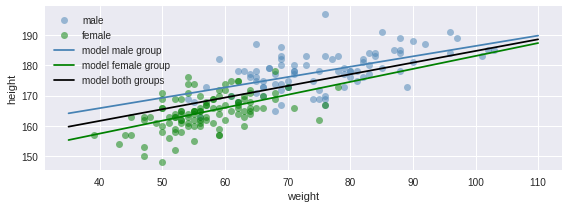

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

mask_m = data.sex == 0
mask_f = data.sex == 1

ax.plot(data.weight[mask_m], data.height[mask_m], 'o', color="steelblue", label="male", alpha=0.5)
ax.plot(data.weight[mask_f], data.height[mask_f], 'o', color="green", label="female", alpha=0.5)

x = np.linspace(35, 110, 50)
ax.plot(x, intercept_m + x * beta_m, color="steelblue", label="model male group")
ax.plot(x, intercept_f + x * beta_f, color="green", label="model female group")
ax.plot(x, intercept + x * beta, color="black", label="model both groups")

ax.set_xlabel("weight")
ax.set_ylabel("height")
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch16-multilevel-linear-model-fit.pdf")
fig.savefig("ch16-multilevel-linear-model-fit.png")